### Intro NESSE Tutorial
This tutorial will walk you through how to use NESSE using analytical solutions to a simple parallel plate detector. The tutorial assumes a basic knowledge of solid state detectors e.g. pn junctions, depletion, how to solve for electric fields, shockley-ramo theorem. 


First we import NESSE and all other required packages for the tutorial.

In [1]:
import os
import sys
sys.path.append(os.getcwd()+ "\\src\\")
import nesse
import numpy as np
import matplotlib.pyplot as plt
import nabPy as Nab

### Detector Setup
Here we will setup a simple parallel plate detector. 

#### Weighting Potential
According to the shockley-ramo theorem, for a depleted detector, the induced current on a conductor in a solid state detector is $$ I_k = q v_d \cdot \nabla W_k(z) $$ where $v_d$ is the drift velocity and $W_k$ is the weighting potential of contact $k$.The weighting potential is obtained by solving the Laplace equation with the potential of contact $k$ set to 1 and all others set to 0. For a parallel plate detector the weighting potential is simply $$ \nabla W(z) =  \frac{1}{L} \^{z}$$, where L is the length between plates. Therefore for a parallel plate detector there all parts of the detector contribute equally to the induced current. Note that this is not true for realistic geometries. 

#### Electric Field
The electric field in the detector causes the electrons and holes to drift, which then induces a current on the contacts. The drift velocity is determined by $$ v_d = \frac{\mu_0 E}{[1 + (\mu_0 E / v_s)^{1/\beta}]^\beta}$$, where $v_s$ is a saturation velocity, β a fit coefficient, and $\mu_0$ the mobility of the electron or hole (more on this later). 
The electric field for a parallel plate detector is $$|E(z)| =  \frac{V}{L} + \frac{N q L}{2 \epsilon} - \frac{N q}{\epsilon}z $$, where $V$ is the voltage difference between plates, $N$ is the impurity density, and $\epsilon$ is the dielectric strength of the detector material.

#### Define Fields in NESSE
Here we do this with the analytical fields above, but this can also be done with potentials or fields imported as arrays. 

In [62]:
L = 0.002
N = 1e16
q = 1.6e-19
epsR_Si = 11.8
eps_0 = 8.8541878128e-12
eps = epsR_Si*eps_0

V = 150

# create square bounds for parallel plate detector
bounds = [[-L/2,L/2],[-L/2,L/2],[0,L]]
# define the grid spacing for each coordinate (z typically needs to be finer)
dx, dy, dz = (1e-4, 1e-4, 1e-5)


WP = nesse.analytical_potential("PPWP", np.vectorize(lambda x,y,z: z/L), bounds, dx, dy, dz)

# Efield = (Ex, Ey, Ez, Emag)
Et = np.vectorize(lambda x,y,z: 0)
Ez = np.vectorize(lambda x,y,z: -(V/L + N*q*L/(2*eps) - N*q*z/eps))
Efield = [Et, Et, Ez, Ez]

EF = nesse.analytical_field("PPEF", Efield, bounds, dx, dy, dz)




Lets plot these so we can see what they look like. 

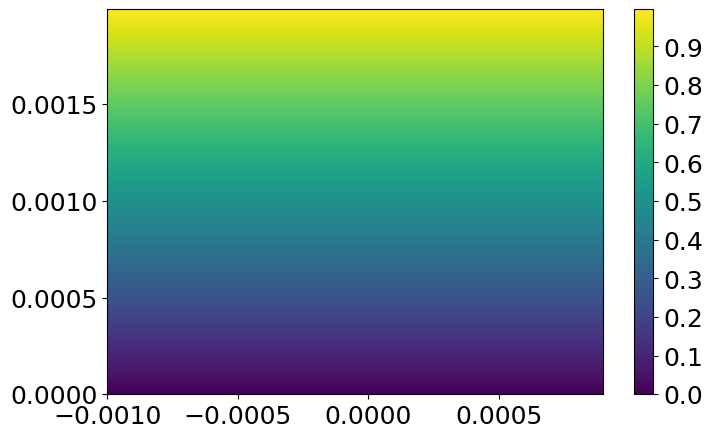

<Figure size 800x500 with 0 Axes>

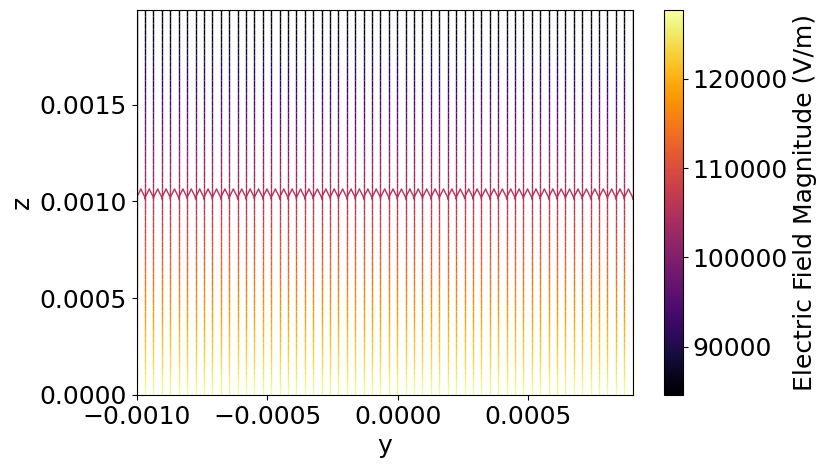

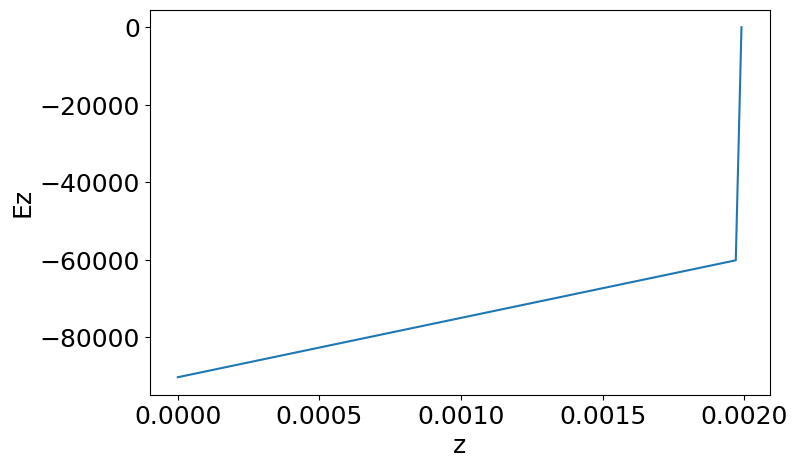

<Figure size 800x500 with 0 Axes>

In [63]:
nesse.plot_potential(WP, x_plane=False)
nesse.plot_field_lines(EF)
nesse.plot_field_1D(EF)

#### Setup NESSE Simulation
Now that we have defined fields we can setup a NESSE Simulation object. 

This primarily needs a weighting potential which effectively defines any contacts we want to find signals for. For this simple tutorial we will only define one weighting potential and one contact. 

It also can take an Electric field, but this doesn't need to be passed on until the you run the simulation.

Temperature of the detector must be defined (in Kelvin). This must be defined because it determines the charge mobility due to a $\frac{300}{T}^\theta$ scaling factor present in all mobilites. $\theta$ is a fit parameter. 

Finally an impurity density profile should be defined, if not NESSE will default to a very pure $1\times 10^{16}$ m $^{-3}$

In [64]:
temp = 140 #K
IDP = lambda x, y, z: 1e16 #impurity density profile, constant 1e16 
sim = nesse.Simulation("PPSim", temp, EF, WP, _impurityConcentration=IDP)

#### Events
Now that we have our fields and detector setup we need some events to create e-h pairs. Normally we would get these events from something like Geant4 which would provide hit locations and energy depositits. But to keep things simple we will define a simple event where all the energy is deposited in a single location near the front face of the detector. To make this similar to a proton event in Nab we deposit 30keV. 

In [49]:
#note that typically an event has multiple deposits so we need an array of position arrays

positions = np.array([[0,0,1e-5]]) #[m,m,m]
energies = np.array([30e3]) #eV
times = np.array([0]) #s
event = nesse.Event(1,positions, energies, times)

#### Simulation of e-h pair generation and drift
Now we have all the components needed to simulate the generation and drifting of electrons and holes in our detector.

Simulation.simulate() is the function to simulate events. All you need for input are the events, step length (ds), and step time (dt). You can also optionally turn on features like coulomb repulsion and diffusion. We will also limit the number of e-h pairs created to keep this running fast.

In [67]:
sim.simulate(np.array([event]),ds=1e-6, dt=1e-9,maxPairs=100)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total quasiparticles: 200


0it [00:00, ?it/s]

array([<nesse.event.Event object at 0x000002B613192C70>], dtype=object)

Hurray! We did the hard part. Now, let's look at what those drift paths look like. Red paths are holes and green are electrons.

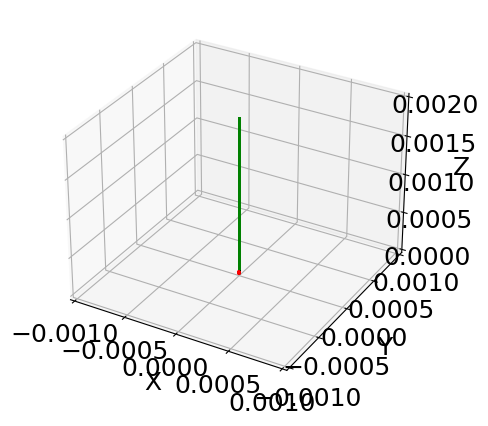

In [58]:
nesse.plot_event_drift(event, bounds)

#### Calculate Induced Current
Now that we have the electron and hole paths we can calculate the induced charge using the weighting potential. At this step we again specify need to specify dt. Most of the time this takes to run is initially solving for the interpolation of the weighting field. 

In [68]:
sim.calculateInducedCurrent(np.array([event]), 1e-9)

Now we plot the current. Note that there is an initial peak from the holes hitting the front contact, then the electrons make their way to the back contact. 

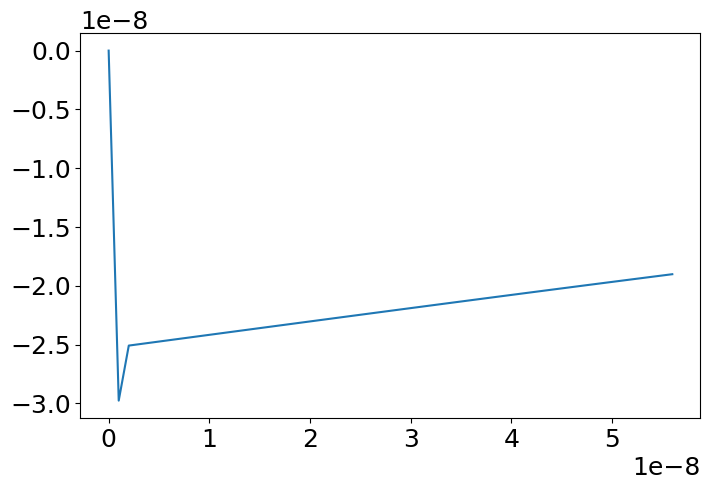

In [69]:
nesse.plot_current(event)

We can add diffusion to make this slightly more interesting.

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Total quasiparticles: 200


0it [00:00, ?it/s]

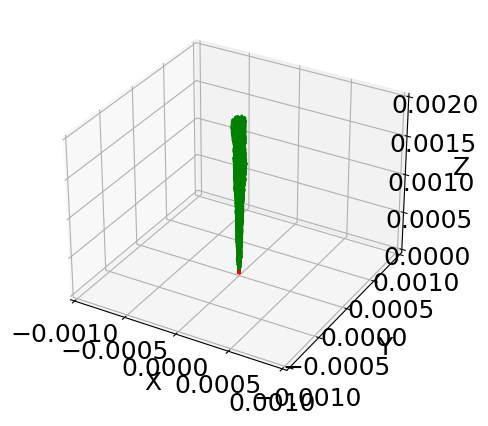

In [70]:
sim.simulate(np.array([event]),ds=1e-6, dt=1e-9,maxPairs=100, diffusion=True)
nesse.plot_event_drift(event, bounds)

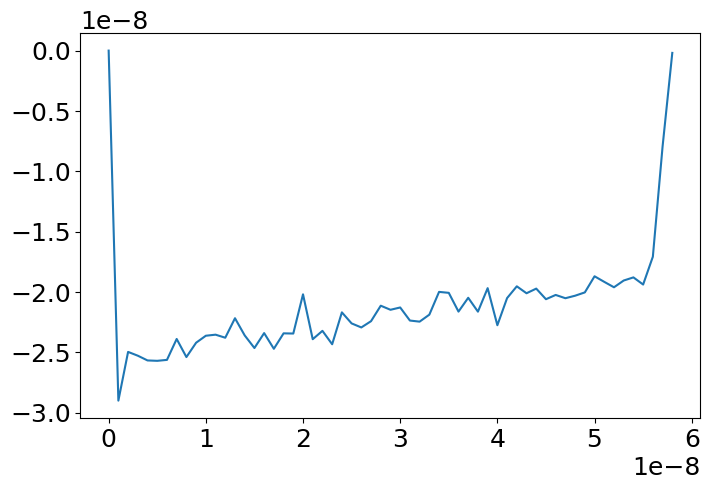

In [71]:
sim.calculateInducedCurrent(np.array([event]), 1e-9)
nesse.plot_current(event)

### Tutorial Complete!
We did it! We succesfuly created a signal for a simple parallel plate detector. For details on more complicated simulations, which mostly involves importing more realistic events and field, please see the full tutorial.